In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

%matplotlib inline

sns.set(style="darkgrid")

In [ ]:
datac = pd.read_csv('/content/drive/MyDrive/third/third/dataforc.csv')
datac['timedelta'] = pd.to_timedelta(datac['timedelta'])
datac['time'] = pd.Timestamp("2004-05-01") + datac['timedelta'] # 1 may 2004 (c) |  1 june 2013 (b)  | 18 Feb 1998 (a)

dataa = pd.read_csv('/content/drive/MyDrive/third/third/datafora.csv')
dataa['timedelta'] = pd.to_timedelta(dataa['timedelta'])
dataa['time'] = pd.Timestamp("1998-02-18") + dataa['timedelta']

datab = pd.read_csv('/content/drive/MyDrive/third/third/dataforb (1).csv')
datab['timedelta'] = pd.to_timedelta(datab['timedelta'])
datab['time'] = pd.Timestamp("2013-06-01") + datab['timedelta']

In [ ]:
all = pd.concat([dataa, datab, datac]).sort_values('time')

# lstm

In [ ]:
# ss = StandardScaler()

In [ ]:
# to_ss = ['bx_gse', 'by_gse', 'bz_gse', 'theta_gse', 'phi_gse', 'bt', 'density', 'speed', 'temperature',]

In [ ]:
# all[to_ss] = ss.fit_transform(all[to_ss])

In [ ]:
all.describe()

,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,temperature,ans
count,7571081,7.571081e+06,7.571081e+06,7.571081e+06,7.571081e+06,7.571081e+06,7.571081e+06,7.571081e+06,7.571081e+06,7.571081e+06,7.571081e+06
mean,1057 days 11:39:15.423987648,-6.502597e-01,1.134111e-01,-1.838567e-02,1.665519e-01,1.941068e+02,5.605064e+00,4.466587e+00,4.325617e+02,1.151039e+05,5.683388e+01
std,652 days 17:53:38.553081536,3.663746e+00,3.973473e+00,3.340869e+00,3.211783e+01,9.675482e+01,3.081545e+00,4.325328e+00,9.995662e+01,1.203189e+05,6.070282e+01
min,0 days 00:00:00,-5.463000e+01,-5.169000e+01,-5.484000e+01,-8.989000e+01,0.000000e+00,3.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,507 days 02:00:00,-3.270000e+00,-2.460000e+00,-1.700000e+00,-2.143000e+01,1.238300e+02,3.660000e+00,1.830000e+00,3.588000e+02,3.979100e+04,1.200000e+01
50%,988 days 01:48:00,-6.700000e-01,1.100000e-01,1.000000e-02,1.600000e-01,1.766500e+02,4.950000e+00,3.390000e+00,4.113100e+02,7.737400e+04,3.500000e+01
75%,1587 days 01:34:00,2.040000e+00,2.650000e+00,1.700000e+00,2.169000e+01,2.866200e+02,6.700000e+00,5.750000e+00,4.874000e+02,1.512220e+05,8.900000e+01
max,2435 days 23:59:00,5.555000e+01,5.760000e+01,5.730000e+01,8.994000e+01,3.600000e+02,7.369000e+01,1.952600e+02,1.198490e+03,6.223700e+06,3.530000e+02


In [ ]:
dataa = all[all['period'] == 'train_a']
datab = all[all['period'] == 'train_b']
datac = all[all['period'] == 'train_c']

In [ ]:
DEVICE = 'cpu'
BATCH_SIZE = 128
SEQ_LEN = 365
HIDDEN_SIZE = 128
LAYERS = 2
EPOCHS = 1000

In [ ]:
def group_split_day(df, seq_len, val_size):
    data = df.copy()
    data['days'] = data['time'].apply(lambda x: (x - pd.Timestamp(1970, 1, 1)).days)
    g = data.groupby('days').agg(['mean', 'std'])
    g.columns = [ "_".join(i) for i in g.columns]
    g = g.reset_index().drop('ans_std', axis=1)
    x, y = g.drop('ans_mean', axis=1), g['ans_mean']
    x = x.fillna(method='pad')
    # train_size = int(len(x)*0.8)
    # x_train, x_test = x[:train_size], x[train_size-seq_len+1:]
    # y_train, y_test = y[:train_size], y[train_size-seq_len+1:]
    if val_size == 0:
        x_train, x_test = x, None
        y_train, y_test = y, None
    else:
        x_train, x_test = x[:-val_size], x[-val_size:]
        y_train, y_test = y[:-val_size], y[-val_size:]
    return x_train, y_train, x_test, y_test

In [ ]:
def group_split(df, seq_len):
    data = df.copy()
    data['hour'] = data['time'].apply(lambda x: (x - pd.Timestamp(1970, 1, 1)).days*24 + (x - pd.Timestamp(1970, 1, 1)).seconds//(60*60))
    g = data.groupby('hour').agg(['mean', 'std'])
    g.columns = [ "_".join(i) for i in g.columns]
    g = g.reset_index().drop('ans_std', axis=1)
    x, y = g.drop('ans_mean', axis=1), g['ans_mean']
    x = x.fillna(method='pad')
    train_size = int(len(x)*0.8)
    x_train, x_test = x[:train_size], x[train_size-seq_len+1:]
    y_train, y_test = y[:train_size], y[train_size-seq_len+1:]
    return x_train, y_train, x_test, y_test

In [ ]:
a_x_train, a_y_train, _, _ = group_split_day(dataa, SEQ_LEN, 0)#group_split(dataa, SEQ_LEN)
b_x_train, b_y_train, b_x_test, b_y_test = group_split_day(datab, SEQ_LEN, 120)#group_split(datab, SEQ_LEN)
c_x_train, c_y_train, _, _ = group_split_day(datac, SEQ_LEN, 0)#group_split(datac, SEQ_LEN)

<ipython-input-63-ec1aa79a3367>:4: FutureWarning: ['period', 'timedelta', 'time'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  g = data.groupby('days').agg(['mean', 'std'])
<ipython-input-63-ec1aa79a3367>:4: FutureWarning: ['period', 'timedelta', 'time'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  g = data.groupby('days').agg(['mean', 'std'])
<ipython-input-63-ec1aa79a3367>:4: FutureWarning: ['period', 'timedelta', 'time'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  g = data.groupby('days').agg(['mean', 'std'])


In [ ]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [ ]:
class SSDataset(Dataset):
    def __init__(self, x, y, seq_len):
        super(Dataset).__init__()
        x = np.float32(x.copy())
        y = np.float32(y.copy())
        self.data = []
        pos = 0
        while pos + seq_len < len(x):
            if np.isnan(x[pos:pos+seq_len]).sum():
                print(x.shape, pos)
            self.data.append((x[pos:pos + seq_len], y[pos + seq_len])) 
            pos += 1

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

In [ ]:
train_dl = DataLoader(SSDataset(a_x_train, a_y_train, SEQ_LEN) + SSDataset(b_x_train, b_y_train, SEQ_LEN) + SSDataset(c_x_train, c_y_train, SEQ_LEN), batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(SSDataset(b_x_test, b_y_test, SEQ_LEN), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def epoch_train(model, dl, crit, optim):
    model.train()
    mean_loss = []
    for x, y in tqdm(dl):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        optim.zero_grad()
        pred, _ = model(x)
        pred = pred[:, -1, :].flatten()
        loss = crit(pred, y)
        loss.backward()
        optim.step()
        mean_loss.append(loss.item())
        x = x.to('cpu')
        y = y.to('cpu')
        del x
        del y
        
    return np.mean(mean_loss)


def epoch_test(model, dl, crit):
    model.eval()
    mean_loss = []
    for x, y in dl:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred, _ = model(x)
        pred = pred[:, -1, :].flatten()
        loss = crit(pred, y)
        mean_loss.append(loss.item())
        x = x.to('cpu')
        y = y.to('cpu')
        del x
        del y
    return np.mean(mean_loss)


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/third/model(daily365).pth')

In [ ]:
# hourly 2.88e+03 test loss
# daily 1081.0 test loss (365 seqlen)

In [ ]:
model = nn.LSTM(19, HIDDEN_SIZE, LAYERS, proj_size=1, batch_first=True).to(DEVICE)
# crit = nn.L1Loss()
crit = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', verbose=True)

for epoch in range(EPOCHS):
    train_loss = epoch_train(model, train_dl, crit, optim)
    test_loss = epoch_test(model, test_dl, crit)
    # scheduler.step(test_loss).
    print(f"{epoch=}, {train_loss=:.4}, {test_loss=:.4}")

In [ ]:
epoch_test(model, test_dl, crit)

1081.5795700073243

# deepAR

In [ ]:
!pip install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, RMSE, MultivariateDistributionLoss

In [ ]:
def group_split_day(df):
    data = df.copy()
    data['days'] = data['time'].apply(lambda x: (x - pd.Timestamp(1970, 1, 1)).days)
    g = data.groupby('days')
    g1 = g.agg(['mean', 'std'])
    g1.columns = [ "_".join(i) for i in g1.columns]
    g1 = g1.drop(['ans_std'], axis=1)
    g2 = g.agg(['first'])['period']
    return g1.join(g2).reset_index()
    # g.columns = [ "_".join(i) for i in g.columns]
    # g = g.reset_index().drop(['ans_std'] + [i + "_first" for i in ["bx_gse", "by_gse", "bz_gse", "theta_gse", "phi_gse", "bt", "density", ]], axis=1)
    # return x

In [ ]:
abc = group_split_day(all)

<ipython-input-7-19abe504003d>:5: FutureWarning: ['period', 'timedelta', 'time'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  g1 = g.agg(['mean', 'std'])


In [ ]:
data = abc

In [ ]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [ ]:
max_encoder_length = 120
max_prediction_length = 120

training_cutoff = data["days"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x['days'] <= training_cutoff],
    time_idx="days",
    target="ans_mean",
    categorical_encoders={"first": NaNLabelEncoder().fit(data['first'])},
    group_ids=["first"],
    static_categoricals=[
        "first"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=['ans_mean'],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/samplers.py:86: UserWarning: Less than 128 samples available for 4933 prediction times. Use batch size smaller than 128. First 10 prediction times with small batch sizes: [10396, 10397, 10398, 10399, 10400, 10403, 10404, 10405, 10406, 10407]
  warnings.warn(


In [ ]:
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
RMSE()(baseline_predictions.output, baseline_predictions.y)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, u

tensor(11.9597)

In [ ]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 3.548133892335755e-05
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 3.548133892335755e-05
INFO: Restoring states from the checkpoint path at /content/.lr_find_4e62854d-b601-4344-847e-30095bd70522.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_4e62854d-b601-4344-847e-30095bd70522.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_4e62854d-b601-4344-847e-30095bd70522.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_4e62854d-b601-4344-847e-30095bd70522.ckpt


suggested learning rate: 3.548133892335755e-05


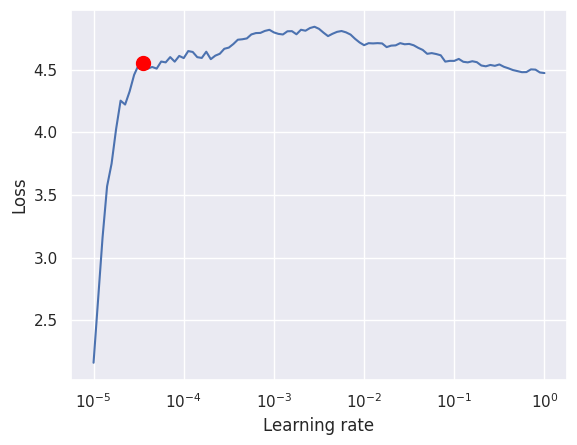

In [ ]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=1e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    optimizer="Adam",
    loss=MultivariateNormalDistributionLoss(rank=30),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 9     
3 | rnn                    | LSTM                               | 11.8 K
4 | distribution_projector | Linear                        

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [ ]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
RMSE()(predictions.output, predictions.y)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


tensor(10.0971)

In [ ]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, n_samples=100, trainer_kwargs=dict(accelerator="cpu")
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Text(0.5, 0.98, 'type: train_b')

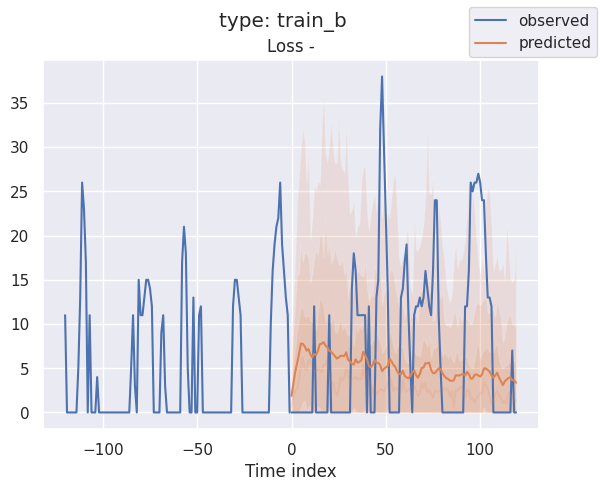

In [ ]:
series = validation.x_to_index(raw_predictions.x)["first"]
# for idx in range(20):  # plot 10 examples
best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)
plt.suptitle(f"type: {series.iloc[0]}")

In [ ]:
# raw_predictions.output.prediction[0,13,:] += np.random.normal(4, 1, size=(100)) 
# raw_predictions.output.prediction[0,44,:] += np.random.normal(7, 4, size=(100))
# raw_predictions.output.prediction[0,45,:] += np.random.normal(8, 4, size=(100)) 
# raw_predictions.output.prediction[0,46,:] += np.random.normal(17, 4, size=(100)) 
# raw_predictions.output.prediction[0,47,:] += np.random.normal(8, 4, size=(100)) 
# raw_predictions.output.prediction[0,48,:] += np.random.normal(7, 4, size=(100)) 


In [ ]:
raw_predictions.output

Output(prediction=tensor([[[ 5.5564,  9.8901,  6.7877,  ...,  0.5869,  0.0000,  0.0000],
         [ 1.8484, 17.3464,  1.4537,  ...,  6.1690,  0.2787,  0.0000],
         [ 0.0000, 22.5430,  0.0000,  ...,  5.7927,  0.0000,  0.0000],
         ...,
         [ 0.0000,  4.5298,  7.3877,  ...,  0.0000, 14.0544,  2.6508],
         [ 0.0000,  4.4057,  5.1950,  ...,  0.6778, 13.0002,  2.8162],
         [ 0.0000,  7.9482,  6.5679,  ...,  3.4452, 10.7927,  0.0000]]]))

Text(0.5, 0.98, 'type: train_b')

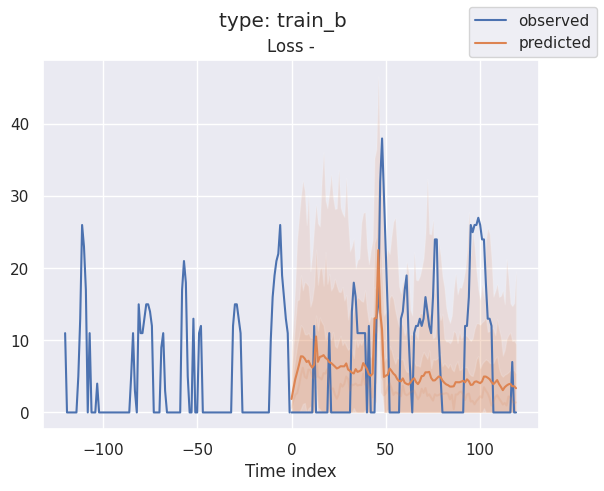

In [ ]:
series = validation.x_to_index(raw_predictions.x)["first"]

best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)
plt.suptitle(f"type: {series.iloc[0]}")

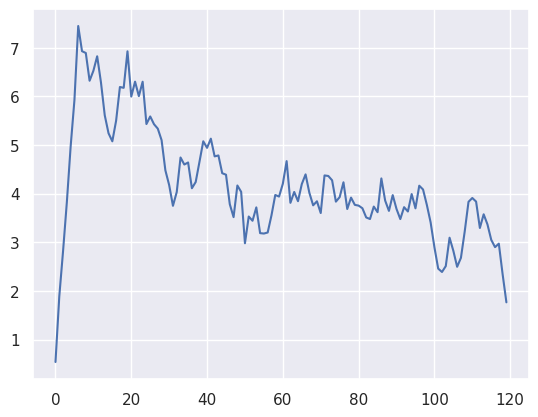

In [ ]:
plt.plot(raw_predictions.output.prediction.mean(-1)[0])